In [218]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import rf_coil_calibration as rfc
import pandas as pd
import seaborn as sns

sns.set_theme()
from lmfit import Model, Parameters
from lmfit.models import LorentzianModel, LinearModel, ConstantModel

In [219]:
df1 = pd.read_csv(Path("least_squares_20210607-153412/results.csv"), sep=";")
# df1

In [220]:
final_data = df1.iloc[[2, 3, 4, 5],:]
final_data.index = [i for i in range(4, 7+1)]
final_data

,Files,Gain,Resistor,Current [mA],Frequency [kHz],ramp_channel,signal_channel,c,ramplitude,rcenter,rsigma,mamplitude,mcenter,msigma,lamplitude,lcenter,lsigma
4,10ohm sensor\no gain\with mw\TEK00004.CSV,1,10.0,3.449374,10,1,2,0.068212,0.001178,0.011313,0.000836,0.003477,0.002449,0.001203,0.001178,-0.006415,0.000836
5,10ohm sensor\no gain\with mw\TEK00005.CSV,1,10.0,6.946773,20,1,2,0.055521,0.000568,0.020576,0.000840,0.003500,0.002719,0.001169,0.000568,-0.015137,0.000840
6,10ohm sensor\no gain\with mw\TEK00006.CSV,1,10.0,8.624502,25,1,2,0.049786,0.000496,0.024910,0.001052,0.003526,0.002738,0.001169,0.000496,-0.019433,0.001052
7,10ohm sensor\no gain\with mw\TEK00007.CSV,1,10.0,9.684884,28,1,2,0.049499,0.000426,0.027590,0.000983,0.003645,0.002707,0.001221,0.000426,-0.022177,0.000983


## Fit TEK00002


In [221]:
model = ConstantModel() + LorentzianModel(prefix="l") + LorentzianModel(prefix="m") +LorentzianModel(prefix="r")

In [222]:
prs = pd.read_csv("TEK00002_temp.csv", names=["a", "b"])

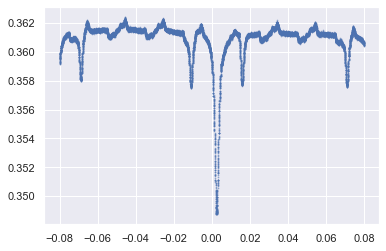

In [223]:
measurement_data = pd.read_csv("TEK00002.CSV", skiprows=16, dtype="float64", header=None, index_col=False)
measurement_data.columns = measurement_data.columns.map(str)
t = measurement_data["0"]
y = measurement_data["2"]
ramp = measurement_data["1"]
plt.scatter(t, y, s=0.5, alpha=0.5)

In [224]:
ramp_dict = dict([("t0",-0.04196902),
                ("amplitude",0.16209982),
                ("frequency",6.00020643),
                ("c",-0.00125244)])

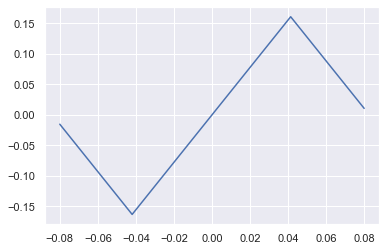

In [225]:
r = rfc.triangle_ramp(t, **ramp_dict)
plt.plot(t, r)



In [226]:
# rising-ramp time interval
start = ramp_dict["t0"]
interval = rfc.data_intervall_positive_ramp(measurement_data, start, ramp_dict["frequency"])
t = interval["0"]
y = interval["2"]
y = np.log(y)

In [227]:
params_d = dict(zip(prs["a"].apply(str), prs["b"]))
useful_params = ["lcenter", "mcenter", "msigma", "lsigma"]
useful_params_dict = dict([(key, params_d[key]) for key in useful_params])
model.set_param_hint("rcenter", expr="2*mcenter - lcenter")
model.set_param_hint("rsigma", expr="lsigma")
params = model.make_params(**useful_params_dict)
fit_result = model.fit(y, params, x=t)

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

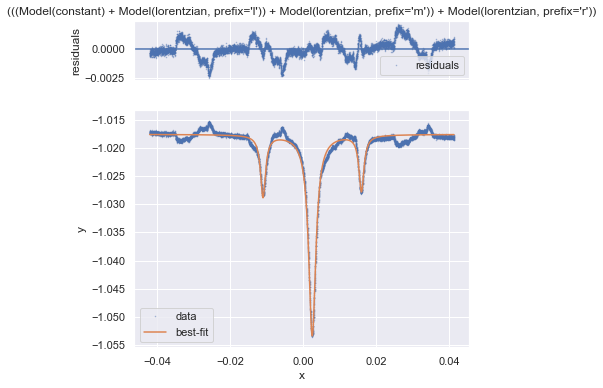

In [228]:
fit_result.plot(data_kws={"markersize": 0.5, "alpha": 0.5})

In [229]:
print(fit_result.fit_report())



[[Model]]
    (((Model(constant) + Model(lorentzian, prefix='l')) + Model(lorentzian, prefix='m')) + Model(lorentzian, prefix='r'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 10417
    # variables        = 8
    chi-square         = 0.00544220
    reduced chi-square = 5.2284e-07
    Akaike info crit   = -150663.479
    Bayesian info crit = -150605.469
[[Variables]]
    c:          -1.01761148 +/- 8.8527e-06 (0.00%) (init = 0)
    lamplitude: -2.8689e-05 +/- 2.0210e-07 (0.70%) (init = 1)
    lcenter:    -0.01093057 +/- 4.8507e-06 (0.04%) (init = -0.01098695)
    lsigma:      8.3289e-04 +/- 6.7895e-06 (0.82%) (init = 0.00128)
    mamplitude: -1.3357e-04 +/- 2.7575e-07 (0.21%) (init = 1)
    mcenter:     0.00254544 +/- 2.0041e-06 (0.08%) (init = 0.0025493)
    msigma:      0.00119187 +/- 3.3117e-06 (0.28%) (init = 0.00145623)
    ramplitude: -2.6010e-05 +/- 1.9509e-07 (0.75%) (init = 1)
    rcenter:     0.01602146 +/- 5.0096e-0

In [230]:
def convert_time_to_current(t_):
    return rfc.triangle_ramp(t_, **ramp_dict) * 1000/10
peak_time_difference = fit_result.best_values["mcenter"] - fit_result.best_values["lcenter"]
peak_current_difference = convert_time_to_current(peak_time_difference)
print("Current difference of peaks:", peak_current_difference, "mA")

Current difference of peaks: 5.235829967814154 mA


In [231]:
df_temp = pd.DataFrame(fit_result.best_values, index=[2])
df_temp["Frequency [kHz]"] = 15.0
df_temp["Current [mA]"] = peak_current_difference
final_data = final_data.append(df_temp)
final_data

,Files,Gain,Resistor,Current [mA],Frequency [kHz],ramp_channel,signal_channel,c,ramplitude,rcenter,rsigma,mamplitude,mcenter,msigma,lamplitude,lcenter,lsigma
4,10ohm sensor\no gain\with mw\TEK00004.CSV,1.0,10.0,3.449374,10.0,1.0,2.0,0.068212,0.001178,0.011313,0.000836,0.003477,0.002449,0.001203,0.001178,-0.006415,0.000836
5,10ohm sensor\no gain\with mw\TEK00005.CSV,1.0,10.0,6.946773,20.0,1.0,2.0,0.055521,0.000568,0.020576,0.000840,0.003500,0.002719,0.001169,0.000568,-0.015137,0.000840
6,10ohm sensor\no gain\with mw\TEK00006.CSV,1.0,10.0,8.624502,25.0,1.0,2.0,0.049786,0.000496,0.024910,0.001052,0.003526,0.002738,0.001169,0.000496,-0.019433,0.001052
7,10ohm sensor\no gain\with mw\TEK00007.CSV,1.0,10.0,9.684884,28.0,1.0,2.0,0.049499,0.000426,0.027590,0.000983,0.003645,0.002707,0.001221,0.000426,-0.022177,0.000983
2,NaN,NaN,NaN,5.235830,15.0,NaN,NaN,-1.017611,-0.000026,0.016021,0.000833,-0.000134,0.002545,0.001192,-0.000029,-0.010931,0.000833


## Fit TEK0008

| C1 | C2 |
| :--- | :--- |
| lamplitude | 1.1040e-04 +/- 4.0460e-06 \(3.66%\) \(init = 0.0001910088\) |
| lcenter | -0.01274176 +/- 1.4585e-05 \(0.11%\) \(init = -0.008073\) |
| lsigma | 6.0800e-04 +/- 3.1507e-05 \(5.18%\) \(init = 0.000304\) |
| mamplitude | 0.00187347 +/- 4.0198e-06 \(0.21%\) \(init = 0.001910088\) |
| mcenter | 0.00246674 +/- 1.2812e-06 \(0.05%\) \(init = 0.00234\) |
| msigma | 5.9978e-04 +/- 1.8197e-06 \(0.30%\) \(init = 0.000608\) |
| ramplitude | 1.2858e-04 +/- 4.0460e-06 \(3.15%\) \(init = 0.0001910088\) |
| rcenter | 0.01767523 +/- 1.4551e-05 \(0.08%\) == '2\*mcenter -lcenter' |
| rsigma | 6.0800e-04 +/- 2.7054e-05 \(4.45%\) \(init = 0.000304\) |
| lfwhm | 0.00121600 +/- 6.3015e-05 \(5.18%\) == '2.0000000\*lsigma' |
| lheight | 0.05780073 +/- 0.00211748 \(3.66%\) == '0.3183099\*lamplitude/max\(1e-15, lsigma\)' |
| mfwhm | 0.00119956 +/- 3.6394e-06 \(0.30%\) == '2.0000000\*msigma' |
| mheight | 0.99427178 +/- 0.00213206 \(0.21%\) == '0.3183099\*mamplitude/max\(1e-15, msigma\)' |
| rfwhm | 0.00121600 +/- 5.4108e-05 \(4.45%\) == '2.0000000\*rsigma' |
| rheight | 0.06731537 +/- 0.00211749 \(3.15%\) == '0.3183099\*ramplitude/max\(1e-15, rsigma\)' |



#### Ramp values
| C1 | C2 |
| :--- | :--- |
| t0 | -0.04126425 +/- 1.3432e-06 \(0.00%\) \(init = -0.025\) |
| amplitude | 0.49813526 +/- 2.0716e-05 \(0.00%\) \(init = 0.5007763\) |
| frequency | 6.00146523 +/- 1.3263e-04 \(0.00%\) \(init = 10\) |
| c | 0.00188720 +/- 1.1792e-05 \(0.62%\) \(init = 0\) |


In [239]:
ramp_dict = dict([("t0",-0.04126425),
                 ("amplitude",0.49813526),
                 ("frequency",6.00146523),
                  ("c",0.00188720)])



In [247]:
final_data = final_data.append(pd.DataFrame({"Current [mA]": convert_time_to_current(0.00246674-(-0.01274176)),
                                "Frequency [kHz]": 52.0,
                                "Center peak offset current": convert_time_to_current(0.00246674)},
                                index=[8]))

In [248]:
print(convert_time_to_current(0.00246674-(-0.01274176)))
# final_data.drop(8, inplace=True)
final_data

17.906244603904703


,Files,Gain,Resistor,Current [mA],Frequency [kHz],ramp_channel,signal_channel,c,ramplitude,rcenter,rsigma,mamplitude,mcenter,msigma,lamplitude,lcenter,lsigma,Center peak offset current
4,10ohm sensor\no gain\with mw\TEK00004.CSV,1.0,10.0,3.449374,10.0,1.0,2.0,0.068212,0.001178,0.011313,0.000836,0.003477,0.002449,0.001203,0.001178,-0.006415,0.000836,NaN
5,10ohm sensor\no gain\with mw\TEK00005.CSV,1.0,10.0,6.946773,20.0,1.0,2.0,0.055521,0.000568,0.020576,0.000840,0.003500,0.002719,0.001169,0.000568,-0.015137,0.000840,NaN
6,10ohm sensor\no gain\with mw\TEK00006.CSV,1.0,10.0,8.624502,25.0,1.0,2.0,0.049786,0.000496,0.024910,0.001052,0.003526,0.002738,0.001169,0.000496,-0.019433,0.001052,NaN
7,10ohm sensor\no gain\with mw\TEK00007.CSV,1.0,10.0,9.684884,28.0,1.0,2.0,0.049499,0.000426,0.027590,0.000983,0.003645,0.002707,0.001221,0.000426,-0.022177,0.000983,NaN
2,NaN,NaN,NaN,5.235830,15.0,NaN,NaN,-1.017611,-0.000026,0.016021,0.000833,-0.000134,0.002545,0.001192,-0.000029,-0.010931,0.000833,NaN
8,NaN,NaN,NaN,17.906245,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.669437


## Linear fit of frequency and current

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

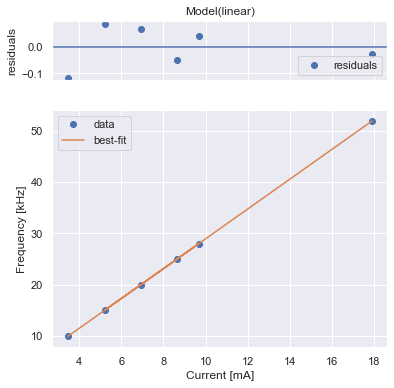

In [249]:
lin = LinearModel()
x = final_data["Current [mA]"]
y = final_data["Frequency [kHz]"]
linpar = lin.guess(y, x=x)
linresult = lin.fit(y, linpar, x=x)
linresult.plot(xlabel="Current [mA]", ylabel="Frequency [kHz]")

In [250]:
print(linresult.fit_report())


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 6
    # variables        = 2
    chi-square         = 0.02964720
    reduced chi-square = 0.00741180
    Akaike info crit   = -27.8608820
    Bayesian info crit = -28.2773630
[[Variables]]
    slope:      2.91142113 +/- 0.00759905 (0.26%) (init = 2.911421)
    intercept: -0.15837057 +/- 0.07447986 (47.03%) (init = -0.1583706)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.882


 ## Calibration constant


In [253]:
nT_per_mA = 2.91142113 * 1000 / 7
stddev = 0.00759905 * 1000 / 7
print(f"Calibration yields {nT_per_mA} +/- {stddev} nT/mA")

Calibration yields 415.91730428571424 +/- 1.0855785714285715 nT/mA
